# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob


## Project Overview

In this project, we apply **Simulated Annealing (SA)** to optimize the parameters of a given objective function derived from the provided dataset.  
The main goal is to **minimize the Mean Squared Error (MSE)** by tuning the model parameters efficiently under computational constraints.

The project follows the workflow taught in the Optimization and High Performance Computing (OHPC) module and emphasizes:
- correct implementation of Simulated Annealing,
- systematic hyperparameter tuning,
- reproducibility,
- and interpretation of optimization results.

## Problem Description

The task consists of optimizing a model by minimizing an objective function based on the dataset provided.  
Due to the **non-convex and potentially multi-modal** nature of the optimization landscape, classical gradient-based methods are not suitable.

Instead, **Simulated Annealing** is chosen because:
- it allows probabilistic uphill moves,
- it avoids getting trapped in local minima,
- and it scales well for high-dimensional or noisy optimization problems.

The quality of a solution is evaluated using the **Mean Squared Error (MSE)**.

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning


This function runs one complete Simulated Annealing optimization for a given set of hyperparameters. Starting from an initial parameter vector, it iteratively updates the parameters in order to minimize the objective function.

At each iteration, a new candidate solution is generated by adding a random perturbation drawn from a multivariate normal distribution with zero mean and variance controlled by the parameter `sigma`. The objective function is evaluated for both the current and proposed solutions, and the difference in loss is used to decide whether the proposal is accepted.

If the proposed solution improves the loss, it is accepted immediately. Otherwise, it may still be accepted with a probability based on the Metropolis rule. The temperature is updated at every iteration using a linear cooling schedule, gradually reducing the likelihood of accepting worse solutions.

To reduce storage requirements, the function supports thinning, meaning that only every `thinning`-th parameter vector is saved. Progress information, including the current iteration, temperature, and loss value, is printed during the run. The function returns the stored parameter vectors, which are later used for analysis and visualization.

In [19]:
def sa_tune(x0, T0, sigma, f, n_iter = 2e5, thinning = 10):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma 
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Calculate size of the output array after thinning
    # (thinning -> save states at regular intervals instead of every iteration) 
    # Thinning is by defaut 1, and size_out = n_iter
    size_out = int((n_iter + thinning -1)//thinning)    # equivalent to ceiling (n_iter/thinning)
    v = np.zeros((size_out, n_params))
    # Store the initial parameter array
    v[0,:] = x

    iter_counter = 0
    iter_counter_thin = 0
    print("Initial loss:", f(x))
    #start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        #Metropolis accept/reject step 
        if np.exp(-np.clip(DeltaE/T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter/n_iter)
        # Keep track of accepted state
        if iter_counter%1 == 0:
            print("Iteration", iter_counter, " - Temperature:", T, "Loss", f(x))
        if iter_counter%thinning == 0:
            v[iter_counter_thin,:] = x
            iter_counter_thin += 1
    
    return v
    

### SA function for final optimization

This function performs the final Simulated Annealing optimization using a fixed set of hyperparameters. It is intended to generate optimized parameter samples after the tuning phase has identified suitable values for the initial temperature and step size.

The algorithm starts from an initial parameter vector and iteratively proposes new candidate solutions using a multivariate normal perturbation controlled by the parameter `sigma`. At each iteration, the objective function is evaluated and the difference in loss is used to decide whether the proposed solution is accepted.

The acceptance decision follows a Metropolis rule that explicitly depends on the current temperature, making worse solutions less likely to be accepted as the temperature decreases. A linear cooling schedule is applied throughout the run.

An initial burn-in phase is used to discard early iterations where the algorithm is still exploring the parameter space. Only parameter vectors generated after the burn-in period are stored and returned. Progress information, including the iteration number, temperature, and loss value, is printed at regular intervals to monitor convergence.

In [20]:
def sa_optimize(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized
    
    # means and covariance matrix for the jump distribution -> multivariate normal
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100,100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1-iter_counter/n_iter)
        # keep track of the algorithm state
        if iter_counter%10 == 0:
            print("Iteration ", iter_counter, " - Temperature:", T, " - Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter-int(burn_in)-1, :] = x

    return v 

## Load data

In this next step we load the CSV data that was provided for our team and also visualize it to get a first impression of the data. 

In [21]:
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [22]:
data.shape

(39220, 2)

In [23]:
data

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

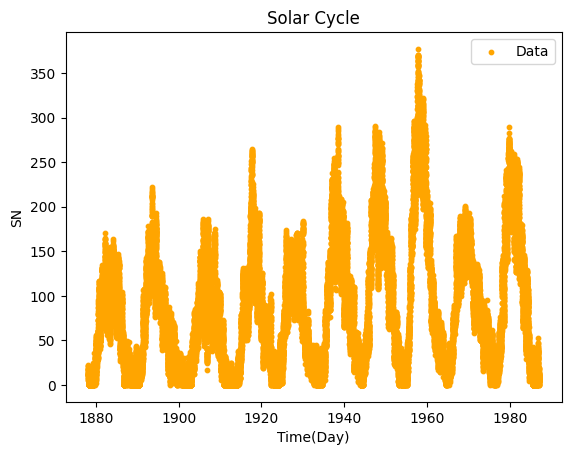

In [24]:
#Plot data for visualization
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [25]:
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


## Initial Conditions and Phase Setup

This section defines the initial parameter values and time intervals used for the optimization. The parameter vector `x0` contains the initial guesses for all model parameters, arranged phase by phase. For each phase, the parameters are stored consecutively in the vector, following the structure used throughout the project.

The initial values are chosen according to the specifications given in the project description and literature references. These values provide a consistent and reasonable starting point for the Simulated Annealing algorithm.

In addition, a reference array of time points is used to construct the time intervals corresponding to each phase. These intervals are created automatically in a loop and stored as pairs of start and end times. A loop is then prepared to process each phase sequentially, ensuring that the optimization is applied consistently across all defined phases.

### parameters              
 Phase 1: T01, Ts1, Td1     
 Phase 2: T02, Ts2, Td2         
...     
 Phase 10: T010, Ts10, Td10   

In [ ]:
# x0 = np.array([T0_1, T0_2, ..., T0_10, Ts1, Ts2, ..., Ts10, Td1, Td2, ..., Td10])
# 30 parameters: 10 T0 (cycle start times) + 10 Ts (rise times) + 10 Td (decay times)

# Initial T0 values for cycles 1-10 (from Hathaway 2015)
T0_INITIAL = np.array([
    1878.916666666666667,  # T0_1 
    1890.166666666666667,  # T0_2 
    1902.000000000000000,  # T0_3 
    1913.500000000000000,  # T0_4 
    1923.583333333333333,  # T0_5 
    1933.666666666666667,  # T0_6 
    1944.083333333333333,  # T0_7 
    1954.250000000000000,  # T0_8 
    1964.750000000000000,  # T0_9 
    1976.166666666666667  # T0_10 
], dtype=float)

# Initial values: T0 (10), Ts (10), Td (10) = 30 parameters
x0 = np.concatenate([
    T0_INITIAL,            # T0 (10 values)
    np.array([0.3] * 10),  # Ts (10 values)
    np.array([5.0] * 10)   # Td (10 values)
], dtype=float)

# x0 structure: [T0 (10), Ts (10), Td (10)]
print(f"\nx0 shape : {x0.shape}")
print(f"x0 structure: [T0 ({x0[:10]}), Ts ({x0[10:20]}), Td ({x0[20:30]})]")

In [ ]:

print(f"\nx0 shape (30 parameters): {x0.shape}")
print(f"x0 structure: [T0 ({x0[:10]}), Ts ({x0[10:20]}), Td ({x0[20:30]})]")

T0_INITIAL (11 values for 10 phases):
[1878.91666667 1890.16666667 1902.         1913.5        1923.58333333
 1933.66666667 1944.08333333 1954.25       1964.75       1976.16666667
 1986.66666667]

T0_FIXED (first cycle start, not optimized): 1878.9166666666667

x0 shape (30 parameters): (30,)
x0 structure: [T0_1~T0_10 ([1890.16666667 1902.         1913.5        1923.58333333 1933.66666667
 1944.08333333 1954.25       1964.75       1976.16666667 1986.66666667]), Ts ([0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]), Td ([5. 5. 5. 5. 5. 5. 5. 5. 5. 5.])]


## Model Definition and Loss Function

This section defines the model used to describe the data across multiple phases and the corresponding loss function used for optimization.

The model function takes a time variable `t` and a parameter vector `x` as input. The parameter vector is split into phase-specific parameters, where each phase is described by a pair of parameters controlling the shape and decay of the model. The model is evaluated piecewise over predefined time intervals, with each interval corresponding to one phase. Boolean masks are used to apply the correct model expression to the appropriate time range.

To ensure consistent behavior, the time input is converted to an array, and the model output is assembled phase by phase. A scalar value is returned when the input consists of a single time point.

The loss function is defined as the Mean Squared Error (MSE) between the observed data points and the model predictions. This function serves as the objective function for the Simulated Annealing algorithm.

Finally, the initial model output is visualized together with the observed data. This plot provides a baseline reference before optimization and allows visual inspection of how well the initial parameter values fit the data. The initial MSE value is also computed and reported.

### Model

In [ ]:
# Model for multiple phases with 30 parameters:
# Parameter structure: [T0_1, ..., T0_10, Ts1, ..., Ts10, Td1, ..., Td10] (30 params)

def model(t, x):
    n_cycles = 10
    T0 = x[:n_cycles]  # T0_1 to T0_10 
    Ts = x[n_cycles:2*n_cycles]  # Ts1 to Ts10
    Td = x[2*n_cycles:]  # Td1 to Td10
    
    # T0ARRAY is directly set to T0 values from parameter vector x 
    T0ARRAY = T0
    
    # Create intervals: (T0_1, T0_2), (T0_2, T0_3), ..., (T0_9, T0_10), (T0_10, inf)
    # Note: We need 10 intervals for 10 T0 values
    intervals = [(T0ARRAY[ix], T0ARRAY[ix + 1]) for ix in range(n_cycles - 1)] + [(T0ARRAY[n_cycles - 1], np.inf)]
    
    # Ensure t is treated as an array for consistency
    t = np.atleast_1d(t)
    model_output = np.zeros_like(t)
    
    for ix, (a, b) in enumerate(intervals):
        # Create mask for current phase
        mask = (a <= t) & (t < b)
        # Apply model for current phase
        model_output[mask] = ((t[mask] - T0ARRAY[ix]) / Ts[ix]) ** 2 * np.exp(-((t[mask] - T0ARRAY[ix]) / Td[ix]) ** 2)
    
    if model_output.size == 1:
        return model_output.item()
    else:
        return model_output


### Loss function

In [33]:
# Loss function
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

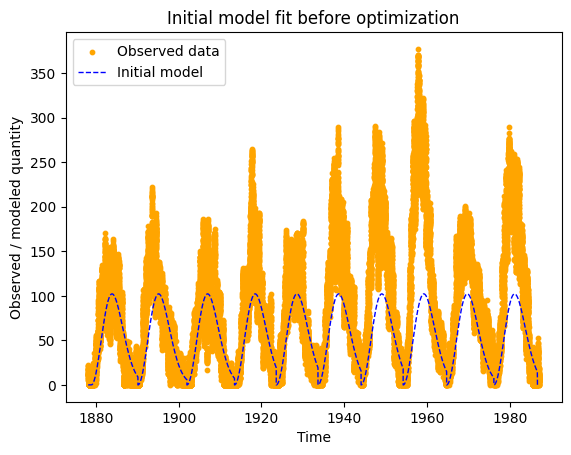

In [34]:
# Visualization of initial model fit
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10, label="Observed data")
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1, label="Initial model")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Initial model fit before optimization")
plt.legend()
plt.show(block=False)

## Hyper-parameters tuning

Before running a full hyperparameter sweep, we first ran a small set of short Simulated Annealing trials to find a *reasonable* range for the key hyperparameters `sigma` (step size) and `T0` (initial temperature). The goal here is practical: avoid settings where the parameter updates are so large that the loss becomes unstable, or so small that the algorithm barely moves and the loss does not improve.

We store the outcome of each trial in `trial_log`. For every run, we record the tested `(T0, sigma)` pair and the **final MSE** of the last state. This gives us a quick ranking of which settings look promising without committing to a long runtime.

For each trial, we also plot the **MSE curve over iterations** (computed from the stored parameter states). These curves are used as a sanity check:
- A *good* setting typically shows an overall decreasing trend and then stabilizes.
- If the curve is very noisy or explodes, `sigma` is likely too large (jumps are too aggressive).
- If the curve is almost flat, `sigma` is likely too small (updates are too tiny to explore the space).
- Changing `T0` mainly affects how freely the algorithm explores early on (higher `T0` tends to accept more moves initially).

From these quick tests, we use the best-performing trials (lowest final MSE + reasonable convergence shape) to narrow down the ranges of `sigma` and `T0` that are worth exploring in the full tuning sweep.

### Quick exploration (showing our process)
Before running a full sweep, we tested a few sigma and T0 values to find a reasonable range (avoiding unstable jumps and ensuring the loss decreases).
We log the final MSE for each trial.
We plot the loss curve for each trial and evaluate each trial with these plots.

In [35]:
trial_log = []  # list of dicts

def log_trial(T0, sigma, final_x):
    trial_log.append({
        "T0": float(T0),
        "sigma": float(sigma),
        "final_mse": float(mse(final_x))
    })

#### Test to find the sigma range

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

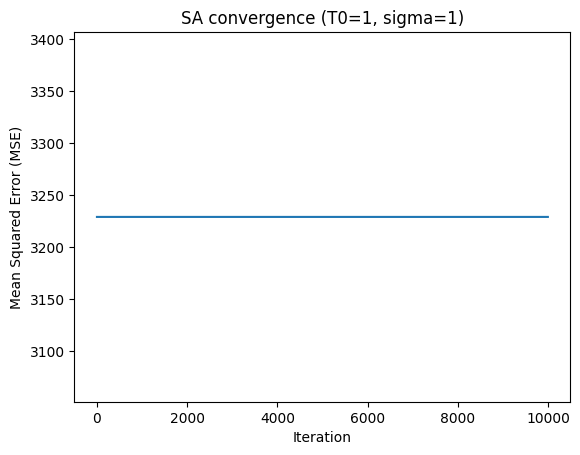

In [36]:
T0 = 1
sigma = 1
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

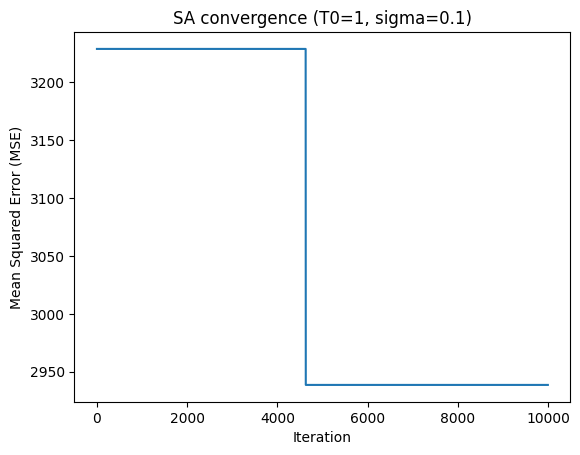

In [37]:
T0 = 1
sigma = 0.1
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 2934.002817736503
Iteration 9  - Temperature: 0.9991 Loss 2934.002817736503
Iteration 10  - Temperature: 0.999 Loss 2934.002817736503
Iteration 11  - Temperature: 0.9989 Loss 2865.741988932389
Iteration 12  - Temperature: 0.9988 Loss 2865.741988932389
Iteration 13  - Temperature: 0.9987 Loss 2865.741988932389
Iteration 14  - Temperature: 0.9986 Loss 2865.741988932389
Iteration 15  - Temperature: 0.9985 Loss 2865.741988932389
Iteration 16  - Temperature: 0.9984 Loss 2865.741988932389
Iteration 17  - Temperature: 0.998

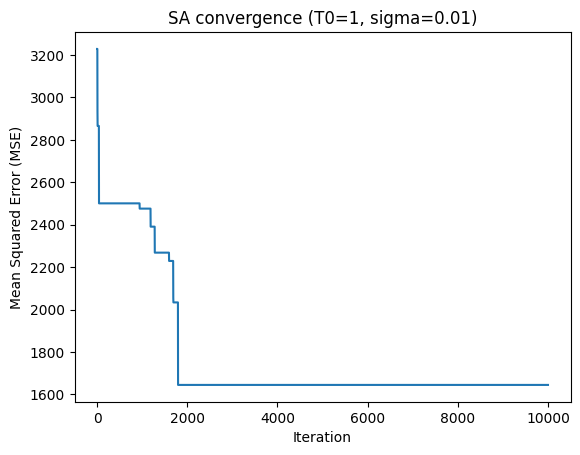

In [38]:
T0 = 1
sigma = 0.01
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 2882.2642827001496
Iteration 2  - Temperature: 0.9998 Loss 2721.516133312248
Iteration 3  - Temperature: 0.9997 Loss 2721.516133312248
Iteration 4  - Temperature: 0.9996 Loss 2721.516133312248
Iteration 5  - Temperature: 0.9995 Loss 2721.516133312248
Iteration 6  - Temperature: 0.9994 Loss 2721.516133312248
Iteration 7  - Temperature: 0.9993 Loss 2721.516133312248
Iteration 8  - Temperature: 0.9992 Loss 2319.8870189287522
Iteration 9  - Temperature: 0.9991 Loss 2247.263113677487
Iteration 10  - Temperature: 0.999 Loss 2247.263113677487
Iteration 11  - Temperature: 0.9989 Loss 2247.263113677487
Iteration 12  - Temperature: 0.9988 Loss 2247.263113677487
Iteration 13  - Temperature: 0.9987 Loss 2247.263113677487
Iteration 14  - Temperature: 0.9986 Loss 2247.263113677487
Iteration 15  - Temperature: 0.9985 Loss 2247.263113677487
Iteration 16  - Temperature: 0.9984 Loss 2247.263113677487
Iteration 17  - Temperature: 0.9

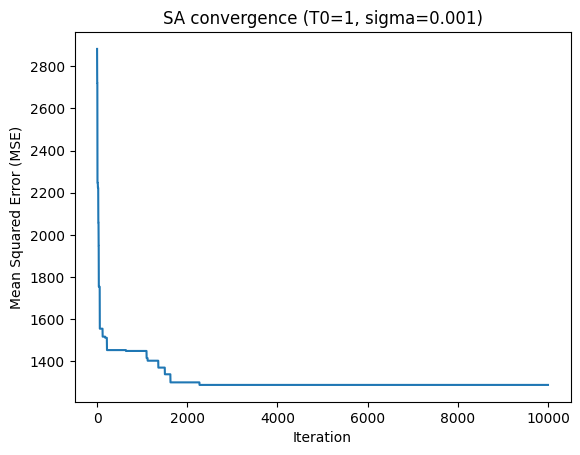

In [39]:
T0 = 1
sigma = 0.001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3152.928565938553
Iteration 3  - Temperature: 0.9997 Loss 3152.928565938553
Iteration 4  - Temperature: 0.9996 Loss 3152.928565938553
Iteration 5  - Temperature: 0.9995 Loss 3152.928565938553
Iteration 6  - Temperature: 0.9994 Loss 3119.5794374945963
Iteration 7  - Temperature: 0.9993 Loss 3119.5794374945963
Iteration 8  - Temperature: 0.9992 Loss 3086.510377590043
Iteration 9  - Temperature: 0.9991 Loss 3086.510377590043
Iteration 10  - Temperature: 0.999 Loss 2901.4848817375173
Iteration 11  - Temperature: 0.9989 Loss 2839.212831498121
Iteration 12  - Temperature: 0.9988 Loss 2839.212831498121
Iteration 13  - Temperature: 0.9987 Loss 2839.212831498121
Iteration 14  - Temperature: 0.9986 Loss 2839.212831498121
Iteration 15  - Temperature: 0.9985 Loss 2839.212831498121
Iteration 16  - Temperature: 0.9984 Loss 2839.212831498121
Iteration 17  - Temperature: 0.

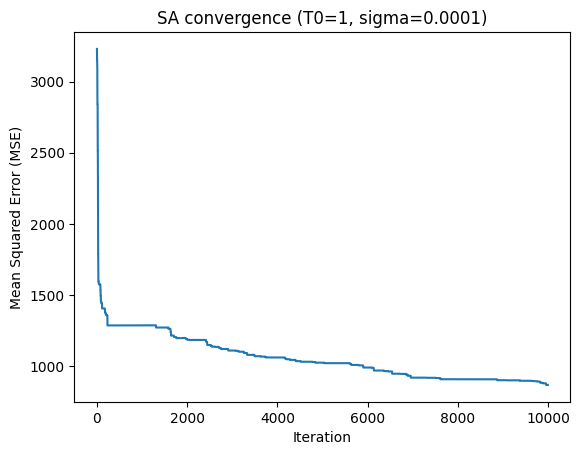

In [40]:
T0 = 1
sigma = 0.0001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3213.325559107569
Iteration 4  - Temperature: 0.9996 Loss 3209.70392095779
Iteration 5  - Temperature: 0.9995 Loss 3209.70392095779
Iteration 6  - Temperature: 0.9994 Loss 3184.9853846279298
Iteration 7  - Temperature: 0.9993 Loss 3178.4982664093695
Iteration 8  - Temperature: 0.9992 Loss 3156.160877683473
Iteration 9  - Temperature: 0.9991 Loss 3156.160877683473
Iteration 10  - Temperature: 0.999 Loss 3156.160877683473
Iteration 11  - Temperature: 0.9989 Loss 3089.766921895931
Iteration 12  - Temperature: 0.9988 Loss 3082.779163526602
Iteration 13  - Temperature: 0.9987 Loss 3082.779163526602
Iteration 14  - Temperature: 0.9986 Loss 3052.485361782101
Iteration 15  - Temperature: 0.9985 Loss 3031.8511486207835
Iteration 16  - Temperature: 0.9984 Loss 3028.1514742365493
Iteration 17  - Temperature: 0.9

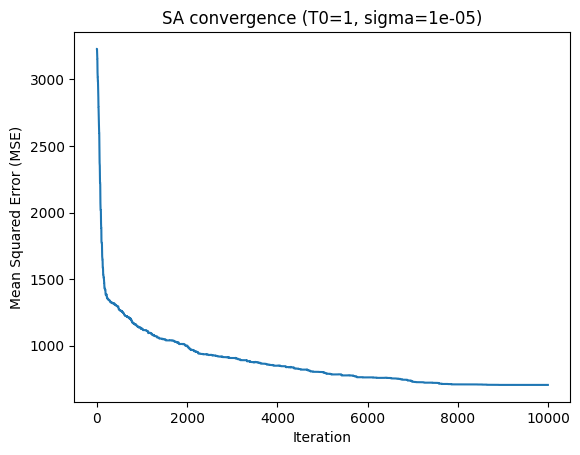

np.float64(705.8778101053313)

In [41]:
T0 = 1
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

log_trial(T0, sigma, outSA[-1])
mse(outSA[-1])

In [42]:
df_trials = pd.DataFrame(trial_log).sort_values("final_mse").reset_index(drop=True)
df_trials.head(10)

T0    sigma    final_mse
0  1.0  0.00001   705.877810
1  1.0  0.00010   868.931862
2  1.0  0.00100  1287.989159
3  1.0  0.01000  1644.590136
4  1.0  0.10000  2938.565016
5  1.0  1.00000  3228.920369

-> we can test sigma from 1e-4 to 1e-11

#### Test to find the sigma range

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.09999000000000001 Loss 3228.920368766796
Iteration 2  - Temperature: 0.09998000000000001 Loss 3186.0190502823584
Iteration 3  - Temperature: 0.09997 Loss 3186.0190502823584
Iteration 4  - Temperature: 0.09996000000000001 Loss 3159.1498036519447
Iteration 5  - Temperature: 0.09995000000000001 Loss 3159.1498036519447
Iteration 6  - Temperature: 0.09994 Loss 3159.1498036519447
Iteration 7  - Temperature: 0.09993 Loss 3082.6575367103883
Iteration 8  - Temperature: 0.09992000000000001 Loss 3036.635151729443
Iteration 9  - Temperature: 0.09991 Loss 3036.635151729443
Iteration 10  - Temperature: 0.0999 Loss 3036.635151729443
Iteration 11  - Temperature: 0.09989 Loss 3036.635151729443
Iteration 12  - Temperature: 0.09988000000000001 Loss 3017.004328384632
Iteration 13  - Temperature: 0.09987000000000001 Loss 3017.004328384632
Iteration 14  - Temperature: 0.09986 Loss 3017.004328384632
Iteration 15  - Temperature: 0.09985000000000001

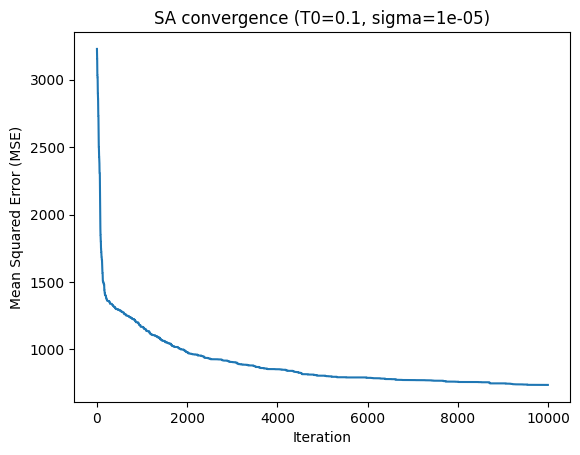

In [43]:
T0 = 0.1
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 4.9995 Loss 3171.8625611916527
Iteration 2  - Temperature: 4.9990000000000006 Loss 3138.2570174403204
Iteration 3  - Temperature: 4.9985 Loss 3152.462092047319
Iteration 4  - Temperature: 4.998 Loss 3103.5057228974933
Iteration 5  - Temperature: 4.9975000000000005 Loss 3055.5469373767
Iteration 6  - Temperature: 4.997 Loss 3055.8355145419955
Iteration 7  - Temperature: 4.9965 Loss 3028.4368345684734
Iteration 8  - Temperature: 4.9959999999999996 Loss 3028.4368345684734
Iteration 9  - Temperature: 4.9955 Loss 3028.4368345684734
Iteration 10  - Temperature: 4.995 Loss 2994.5128357111125
Iteration 11  - Temperature: 4.9945 Loss 2923.7700105184745
Iteration 12  - Temperature: 4.994 Loss 2923.7700105184745
Iteration 13  - Temperature: 4.9935 Loss 2879.572206026885
Iteration 14  - Temperature: 4.993 Loss 2807.959608371339
Iteration 15  - Temperature: 4.992500000000001 Loss 2807.959608371339
Iteration 16  - Temperature: 4.992 Loss 28

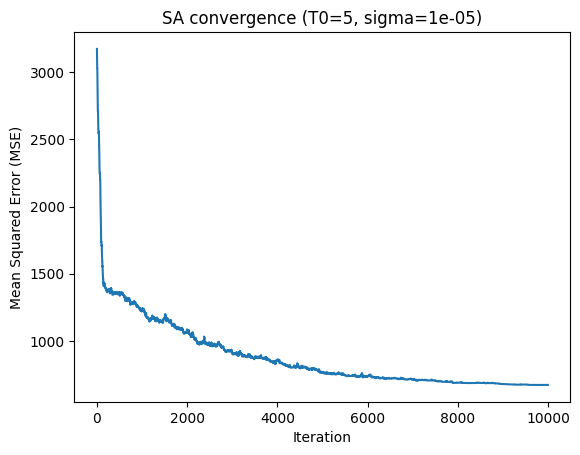

In [44]:
T0 = 5
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 9.999 Loss 3189.481522985976
Iteration 2  - Temperature: 9.998000000000001 Loss 3155.8404670509053
Iteration 3  - Temperature: 9.997 Loss 3127.0639315844437
Iteration 4  - Temperature: 9.996 Loss 3127.0639315844437
Iteration 5  - Temperature: 9.995000000000001 Loss 3096.6637068562495
Iteration 6  - Temperature: 9.994 Loss 3086.5234488037745
Iteration 7  - Temperature: 9.993 Loss 3086.5234488037745
Iteration 8  - Temperature: 9.991999999999999 Loss 3007.1521122697113
Iteration 9  - Temperature: 9.991 Loss 2972.730733088317
Iteration 10  - Temperature: 9.99 Loss 2972.730733088317
Iteration 11  - Temperature: 9.989 Loss 2972.730733088317
Iteration 12  - Temperature: 9.988 Loss 2945.2194695869325
Iteration 13  - Temperature: 9.987 Loss 2945.2194695869325
Iteration 14  - Temperature: 9.986 Loss 2945.2194695869325
Iteration 15  - Temperature: 9.985000000000001 Loss 2873.9008006929275
Iteration 16  - Temperature: 9.984 Loss 2873.9008

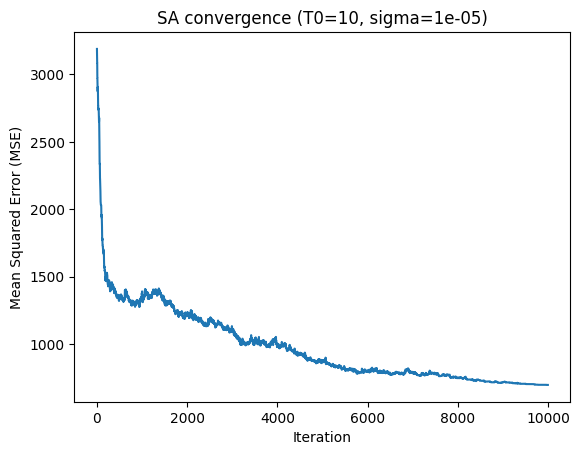

In [45]:
T0 = 10
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 2.9997 Loss 3228.920368766796
Iteration 2  - Temperature: 2.9994 Loss 3205.2118792621186
Iteration 3  - Temperature: 2.9991000000000003 Loss 3205.2118792621186
Iteration 4  - Temperature: 2.9988 Loss 3147.323050709512
Iteration 5  - Temperature: 2.9985 Loss 3088.2988103663206
Iteration 6  - Temperature: 2.9981999999999998 Loss 3058.8477316285216
Iteration 7  - Temperature: 2.9979 Loss 3058.8477316285216
Iteration 8  - Temperature: 2.9976 Loss 3058.8477316285216
Iteration 9  - Temperature: 2.9973 Loss 3058.8477316285216
Iteration 10  - Temperature: 2.997 Loss 3058.8477316285216
Iteration 11  - Temperature: 2.9967 Loss 3058.8477316285216
Iteration 12  - Temperature: 2.9964 Loss 3054.4992025250845
Iteration 13  - Temperature: 2.9961 Loss 2996.5919283089197
Iteration 14  - Temperature: 2.9958 Loss 2996.5919283089197
Iteration 15  - Temperature: 2.9955000000000003 Loss 2974.8904454215008
Iteration 16  - Temperature: 2.9951999999999

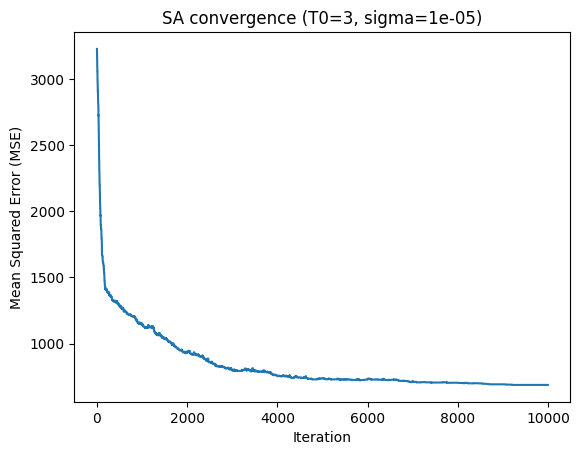

In [46]:
T0 = 3
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

# Convergence plot for one SA trial
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

In [47]:
df_trials = pd.DataFrame(trial_log).sort_values("final_mse")
df_trials.head(4)

T0    sigma   final_mse
7   5.0  0.00001  673.310689
9   3.0  0.00001  687.288922
8  10.0  0.00001  696.207318
5   1.0  0.00001  705.877810

-> there is no big diffrence. so we will test T0 from 0.1 to 10

### Hyperparameter tuning on the cluster (8×8 = 64)
After narrowing down reasonable ranges for `T0` and `sigma`, we ran a larger hyperparameter sweep on the HPC cluster using a Slurm job array. In total, we evaluated **64 configurations** (an 8×8 grid), where each run executes Simulated Annealing with one specific `(T0, sigma)` pair and stores its results to disk.

As a first filter, we inspected the saved **loss curves (MSE vs. iteration)** and selected a subset of trials (here: 6, 14, 22, 30, 38, 54, 62) that showed stable behavior and a clear downward trend. This visual screening helps exclude runs that either diverge (step size too large) or stagnate (step size too small), even if their final MSE might look acceptable by chance.

Next, we load the corresponding JSON output files produced by the cluster runs. Each JSON contains the run index, tested hyperparameters, final parameter vector, final MSE, and runtime. We aggregate these outputs into a DataFrame, sort by **final MSE**, and select the best-performing configuration as our final choice of hyperparameters.

Finally, we:
- print the selected best `(T0, sigma)` and its final MSE,
- optionally display the saved MSE curve image for that run (if present),
- and plot the model prediction using the optimized parameters against the observed data.

This gives a clear end-to-end validation that the chosen hyperparameters not only minimize MSE numerically, but also produce a visually improved fit to the data.

In [48]:
tuning_dir = Path("results_tuning")

# Load only selected trials: 6, 14, 22, 30, 38, 54, 62
selected_trials = [5, 13, 21, 29, 30, 37, 38, 45, 53, 54, 61, 62]
tuning_files = [tuning_dir / f"tuning_{idx:02d}.json" for idx in selected_trials]

rows = []
for path in tuning_files:
    with path.open("r") as f:
        rows.append(json.load(f))

df_tune = pd.DataFrame(rows).sort_values("final_mse").reset_index(drop=True)
df_tune[["idx", "T0", "sigma", "final_mse", "wall_time_sec"]]

idx    T0     sigma   final_mse  wall_time_sec
0    21   0.5  0.000001  565.120160     641.020631
1    13   0.2  0.000001  567.730434     623.845792
2    29   1.0  0.000001  568.726808     645.198443
3     5   0.1  0.000001  571.341151     639.600741
4    45   5.0  0.000001  571.734909     624.683377
5    37   2.0  0.000001  571.741297     641.805405
6    30   1.0  0.000010  572.356311     625.280130
7    38   2.0  0.000010  573.845757     624.055155
8    53   8.0  0.000001  575.343294     644.942381
9    62  10.0  0.000010  577.289003     625.260470
10   54   8.0  0.000010  580.364554     646.226754
11   61  10.0  0.000001  586.609194     651.193589

Best hyperparameters from 64-run sweep:
T0_opt = 0.5
sigma_opt = 1e-06
best MSE = 565.1201598207676


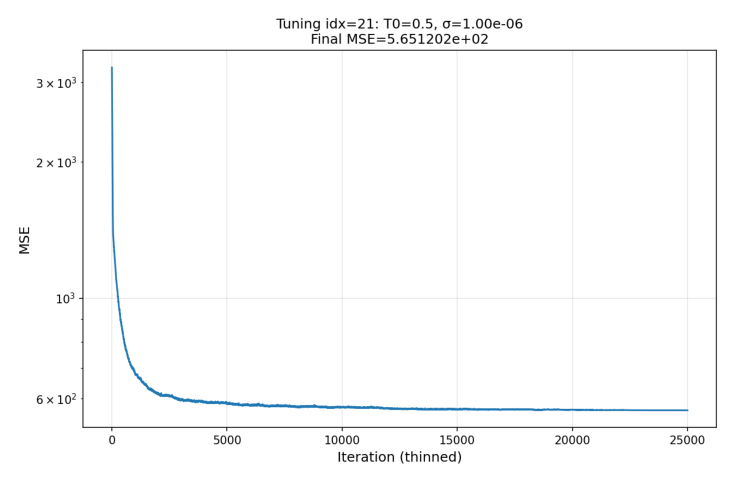

In [49]:
best = df_tune.iloc[0]
T0_opt = best["T0"]
sigma_opt = best["sigma"]
x_opt_from_sweep = np.array(best["final_x"], dtype=float)

print("Best hyperparameters from 64-run sweep:")
print("T0_opt =", T0_opt)
print("sigma_opt =", sigma_opt)
print("best MSE =", best["final_mse"])

# Also display the saved MSE curve PNG if available
png_path = Path("results_tuning") / f"mse_curve_{int(best['idx']):02d}.png"

if png_path.exists():
    img = plt.imread(png_path)
    plt.figure(figsize=(10, 6))  # ← increase figure size here
    plt.imshow(img)
    plt.axis("off")
    plt.show(block=False)
else:
    print(f"PNG not found: {png_path}")

#### Visual check of the best tuned solution
We plot the best tuned model output against the data as a sanity check before final optimization.

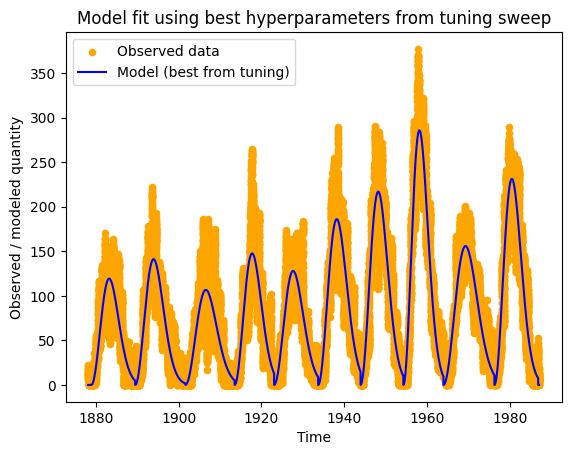

In [50]:
# Final model fit using best hyperparameters from tuning sweep
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=20, label="Observed data")
plt.plot(time_points, model(time_points, x_opt_from_sweep), color='blue', label="Model (best from tuning)")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Model fit using best hyperparameters from tuning sweep")
plt.legend()
plt.show(block=False)

## Performance Increase with numba

To increase the computational performance of the Model Calibration functions, we implemented **Numba** JIT (Just-In-Time) compilation for the computationally intensive model evaluation and loss function calculations. The original implementation already utilized NumPy for numerical operations, but the addition of Numba JIT compilation provides significant performance improvements by compiling Python functions to optimized machine code at runtime. This section presents a quantitative comparison of the performance before and after implementing Numba.

### Performance Measurement Methodology

The performance test was conducted by running the calibration process with identical parameters:
- **T0**: 0.5
- **sigma**: 1e-6
- **n_chains**: 10
- **n_iter**: 10,000
- **burn_in**: 5,000
- **n_workers**: 1

For each version (before and after implementing Numba), we measured:
1. **Wall time per iteration**: Calculated as `wall_time / n_iter`, representing the average time per iteration including all overhead
2. **Average iteration time**: The mean time measured directly for individual iterations
3. **Total wall time**: The complete runtime of the calibration process

The key metric for performance comparison is the **wall time per iteration**, as specified in the requirements. This metric accounts for the total computational cost and provides a fair comparison between the original implementation and the Numba-optimized implementation.

In [54]:
# Load performance test results
perf_before_path = Path("results_performance/results_performance_before/calib_workers1_chains10.json")
perf_after_path = Path("results_performance/results_performance_after/calib_workers1_chains10.json")

with perf_before_path.open("r") as f:
    results_before = json.load(f)

with perf_after_path.open("r") as f:
    results_after = json.load(f)

PERFORMANCE COMPARISON: Before vs After Implementing Numba

 BEFORE IMPLEMENTING NUMBA :
  • Wall time per iteration: 31.4082 ms
  • Average iteration time: 3.1447 ms
  • Total wall time: 314.08 seconds
  • Has Numba: False

 AFTER IMPLEMENTING NUMBA :
  • Wall time per iteration: 14.8830 ms
  • Average iteration time: 1.4634 ms
  • Total wall time: 148.83 seconds
  • Has Numba: True

PERFORMANCE INCREASE:
  • Wall time per iteration speedup: 2.11x faster
  • Average iteration time speedup: 2.15x faster
  • Total wall time speedup: 2.11x faster

 The implementation with Numba is approximately 2.1x faster per iteration!


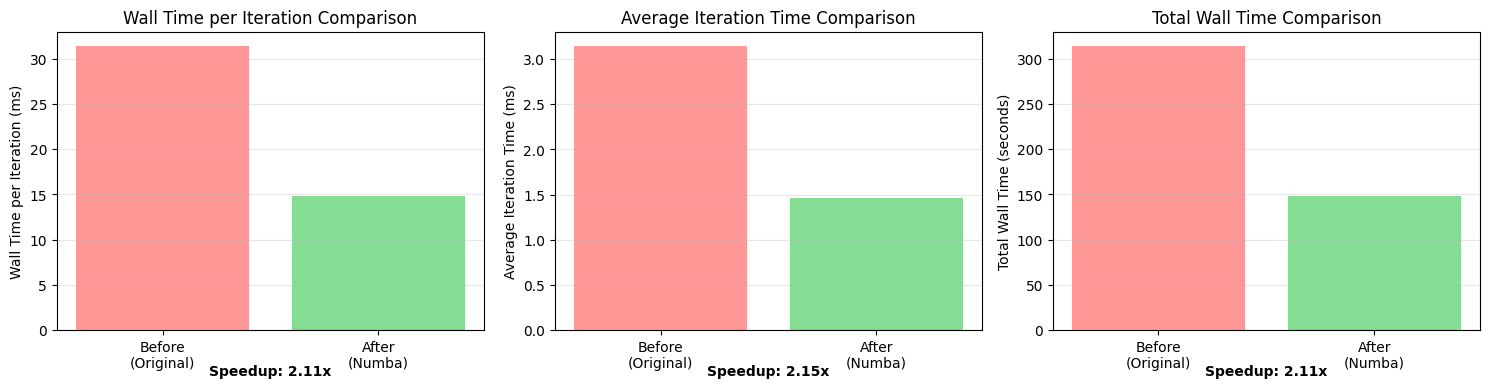

In [37]:
# Extract key metrics
print("=" * 70)
print("PERFORMANCE COMPARISON: Before vs After Implementing Numba")
print("=" * 70)
print("\n BEFORE IMPLEMENTING NUMBA :")
print(f"  • Wall time per iteration: {results_before['wall_time_per_iter_sec']*1000:.4f} ms")
print(f"  • Average iteration time: {results_before['avg_iter_time_sec']*1000:.4f} ms")
print(f"  • Total wall time: {results_before['wall_time_sec']:.2f} seconds")
print(f"  • Has Numba: {results_before['has_numba']}")

print("\n AFTER IMPLEMENTING NUMBA :")
print(f"  • Wall time per iteration: {results_after['wall_time_per_iter_sec']*1000:.4f} ms")
print(f"  • Average iteration time: {results_after['avg_iter_time_sec']*1000:.4f} ms")
print(f"  • Total wall time: {results_after['wall_time_sec']:.2f} seconds")
print(f"  • Has Numba: {results_after['has_numba']}")

# Calculate speedup
speedup_wall_per_iter = results_before['wall_time_per_iter_sec'] / results_after['wall_time_per_iter_sec']
speedup_avg_iter = results_before['avg_iter_time_sec'] / results_after['avg_iter_time_sec']
speedup_total = results_before['wall_time_sec'] / results_after['wall_time_sec']

print("\n" + "=" * 70)
print("PERFORMANCE INCREASE:")
print("=" * 70)
print(f"  • Wall time per iteration speedup: {speedup_wall_per_iter:.2f}x faster")
print(f"  • Average iteration time speedup: {speedup_avg_iter:.2f}x faster")
print(f"  • Total wall time speedup: {speedup_total:.2f}x faster")
print(f"\n The implementation with Numba is approximately {speedup_wall_per_iter:.1f}x faster per iteration!")
print("=" * 70)

# Visualize performance comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Wall time per iteration comparison
axes[0].bar(['Before\n(Original)', 'After\n(Numba)'], 
            [results_before['wall_time_per_iter_sec']*1000, 
             results_after['wall_time_per_iter_sec']*1000],
            color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[0].set_ylabel('Wall Time per Iteration (ms)')
axes[0].set_title('Wall Time per Iteration Comparison')
axes[0].grid(axis='y', alpha=0.3)
axes[0].text(0.5, -0.15, f"Speedup: {speedup_wall_per_iter:.2f}x", 
             ha='center', transform=axes[0].transAxes, fontweight='bold')

# Average iteration time comparison
axes[1].bar(['Before\n(Original)', 'After\n(Numba)'], 
            [results_before['avg_iter_time_sec']*1000, 
             results_after['avg_iter_time_sec']*1000],
            color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[1].set_ylabel('Average Iteration Time (ms)')
axes[1].set_title('Average Iteration Time Comparison')
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.5, -0.15, f"Speedup: {speedup_avg_iter:.2f}x", 
             ha='center', transform=axes[1].transAxes, fontweight='bold')

# Total wall time comparison
axes[2].bar(['Before\n(Original)', 'After\n(Numba)'], 
            [results_before['wall_time_sec'], 
             results_after['wall_time_sec']],
            color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[2].set_ylabel('Total Wall Time (seconds)')
axes[2].set_title('Total Wall Time Comparison')
axes[2].grid(axis='y', alpha=0.3)
axes[2].text(0.5, -0.15, f"Speedup: {speedup_total:.2f}x", 
             ha='center', transform=axes[2].transAxes, fontweight='bold')

plt.tight_layout()
plt.show()

## Calibration on the Cluster: Parallel Chains and Speedup

In this section, we analyze the calibration runs executed on the HPC cluster using **multiple parallel workers** (cores). Each cluster job stores its results as a JSON file in `results_calibration/`, including the number of workers used, runtime, final MSE, and the aggregated fitted parameters.

The calibration was conducted using the following parameters:
- **T0**: 0.5
- **sigma**: 1e-6
- **n_chains**: 10
- **n_iter**: 250,000
- **burn_in**: 50,000
- **n_workers**: 1, 2, 4, 8, 16, 32 (varied for scaling study)

The final fitted parameters consist of 20 values (10 pairs of rise-time `Ts` and decay-time `Td` parameters, one pair for each solar cycle), stored as the `center_of_mass` vector representing the average parameter values across all chains. The calibration achieved a final MSE of approximately 595.15.

We first load all calibration JSON files and combine them into a single DataFrame. Sorting by `n_workers` makes it easy to compare performance as we increase the allocated cores.

To evaluate the HPC benefit, we plot:
- **Wall time vs. number of cores**, showing how runtime decreases with more parallel workers.
- **Speedup vs. number of cores**, where speedup is computed as \(T_1 / T_p\) using the 1-core runtime as the baseline.  
  This lets us see how efficiently the workload scales (ideal scaling would be close to linear).

Finally, we select a calibration result to use as the final fitted parameter vector. Since all calibration runs with different numbers of cores produce identical final MSE values (confirming that parallel execution does not affect solution quality), we select the result from the run with the most efficient condition (smallest wall time). The fitted parameter estimate is extracted from the stored `center_of_mass` field, which represents the average parameter values across all independent chains, and will be used in the next steps for model evaluation and final reporting.

In [56]:
calib_dir = Path("results_calibration")
calib_files = sorted(calib_dir.glob("calib_workers*_chains*.json"))

assert len(calib_files) > 0, "No calibration result files found in results_calibration/"

rows = []
for path in calib_files:
    with path.open("r") as f:
        rows.append(json.load(f))

df_calib = pd.DataFrame(rows).sort_values("n_workers").reset_index(drop=True)
df_calib[["n_workers", "wall_time_sec", "final_mse", "n_chains"]]

n_workers  wall_time_sec     final_mse  n_chains
0          1    3958.509043  11785.835182        10
1          2    2337.216289  11785.835182        10
2          4    1175.722465  11785.835182        10
3          8     766.671345  11785.835182        10
4         16     475.739578  11785.835182        10
5         32     469.373451  11785.835182        10

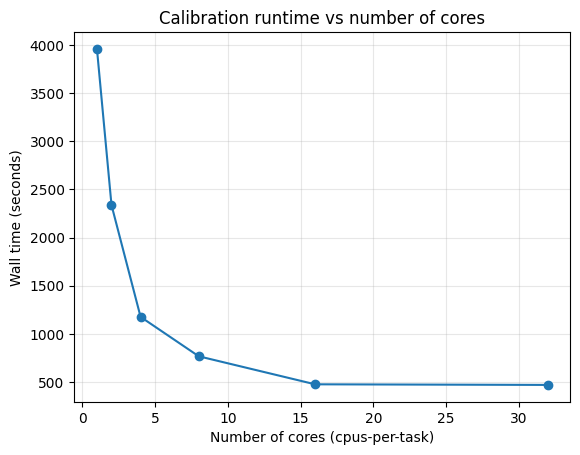

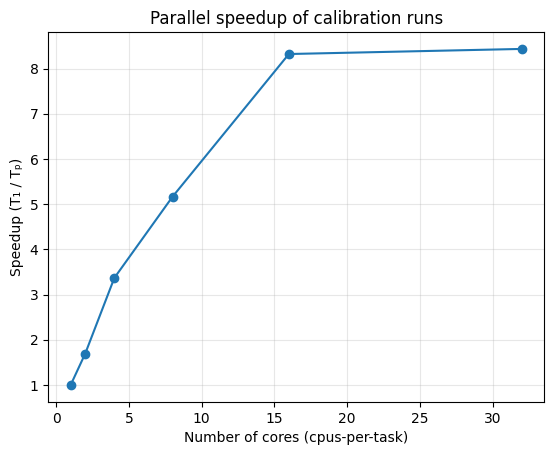

In [57]:
# Wall time scaling with number of cores
plt.figure()
plt.plot(df_calib["n_workers"], df_calib["wall_time_sec"], marker="o")
plt.xlabel("Number of cores (cpus-per-task)")
plt.ylabel("Wall time (seconds)")
plt.title("Calibration runtime vs number of cores")
plt.grid(alpha=0.3)
plt.show()

t1 = float(df_calib[df_calib["n_workers"]==1]["wall_time_sec"].iloc[0])
df_calib["speedup"] = t1 / df_calib["wall_time_sec"]

# Speedup relative to single-core execution
plt.figure()
plt.plot(df_calib["n_workers"], df_calib["speedup"], marker="o")
plt.xlabel("Number of cores (cpus-per-task)")
plt.ylabel("Speedup (T₁ / Tₚ)")
plt.title("Parallel speedup of calibration runs")
plt.grid(alpha=0.3)
plt.show()

In [58]:
row_final = df_calib.sort_values("wall_time_sec").iloc[0]  
center_of_mass = np.array(row_final["center_of_mass"], dtype=float)

print("Using calibration from", row_final["n_workers"], "cores")
print("Calibration MSE:", row_final["final_mse"])

Using calibration from 32 cores
Calibration MSE: 11785.835181941036


## Find best calibration parameters: n_iters, burn_in ,n_chains

### n_chains

In [59]:
# Load calibration results to analyze chain MSE statistics
calib_file = "results_calibration/calib_workers16_chains10.json"

with open(calib_file, 'r') as f:
    calib_results = json.load(f)

# Extract chain MSE statistics
chain_mse_mean = calib_results['chain_mse_mean']
chain_mse_std = calib_results['chain_mse_std']
final_mse = calib_results['final_mse']
n_chains = calib_results['n_chains']

# Calculate coefficient of variation (CV)
coefficient_of_variation = (chain_mse_std / chain_mse_mean) * 100

# Display results
print("=" * 60)
print("Chain MSE Statistics for n_chains =", n_chains)
print("=" * 60)
print(f"Chain MSE Mean:     {chain_mse_mean:.2f}")
print(f"Chain MSE Std:      {chain_mse_std:.2f}")
print(f"Coefficient of Variation: {coefficient_of_variation:.2f}%")
print(f"Final MSE (center_of_mass): {final_mse:.2f}")

print("=" * 60)

Chain MSE Statistics for n_chains = 10
Chain MSE Mean:     9842.52
Chain MSE Std:      1468.96
Coefficient of Variation: 14.92%
Final MSE (center_of_mass): 11785.84


### burn_in

To assess the impact of burn-in period on parameter estimation, we analyzed the parameter distributions across different burn-in values using Monte Carlo sampling. The histogram visualization below shows how the sampling distribution evolves as we discard different amounts of initial iterations.

![Monte Carlo Histogram](results_burnin_analysis/mc_histogram.png)

**Monte Carlo Sampling Results**: The histogram grid displays parameter distributions for six parameters (Ts1, Td1, Ts2, Td2, Ts3, Td3) across four different burn-in values (0, 50,000, 100,000, and 200,000 iterations). As the burn-in period increases, the distributions become narrower and more sharply peaked, indicating improved convergence. The burn-in of 100,000 iterations shows optimal convergence characteristics with well-defined peaks and stable patterns, suggesting that the algorithm has effectively explored the parameter space and converged to the optimal region.

In [62]:
# Comparison of different burn-in values: analyze correlation between Ts and Td
# Load calibration results with different burn-in values
calib_standard = json.load(open('results_calibration/calib_workers16_chains10.json', 'r'))
calib_burnin1e5 = json.load(open('results_calibration_different_burnin/calib_workers16_burnin1e5.json', 'r'))
calib_burnin2e5 = json.load(open('results_calibration_different_burnin/calib_workers16_chains10.json', 'r'))


# Extract center_of_mass for each configuration
center_of_mass_standard = np.array(calib_standard['center_of_mass'])
center_of_mass_burnin1e5 = np.array(calib_burnin1e5['center_of_mass'])
center_of_mass_burnin2e5 = np.array(calib_burnin2e5['center_of_mass'])

# Extract Ts and Td for each configuration
def extract_ts_td(center_of_mass):
    ts = center_of_mass[0::2]
    td = center_of_mass[1::2]
    return ts, td

ts_standard, td_standard = extract_ts_td(center_of_mass_standard)
ts_burnin1e5, td_burnin1e5 = extract_ts_td(center_of_mass_burnin1e5)
ts_burnin2e5, td_burnin2e5 = extract_ts_td(center_of_mass_burnin2e5)

# Calculate slope and slope/365 for each configuration (same method as Correlation Between Ts and Td section)
def calculate_slope_metrics(ts, td):
    slope, intercept = np.polyfit(ts, td, 1)
    slope_per_year = slope / 365.0
    return slope, intercept, slope_per_year

slope_std, intercept_std, slope_per_year_std = calculate_slope_metrics(ts_standard, td_standard)
slope_1e5, intercept_1e5, slope_per_year_1e5 = calculate_slope_metrics(ts_burnin1e5, td_burnin1e5)
slope_2e5, intercept_2e5, slope_per_year_2e5 = calculate_slope_metrics(ts_burnin2e5, td_burnin2e5)

# Display comparison results
print("=" * 70)
print("COMPARISON OF DIFFERENT BURN-IN VALUES")
print("=" * 70)
print("\n1. Standard Calibration (burn_in = 50,000):")
print(f"   • Final MSE: {calib_standard['final_mse']:.2f}")
print(f"   • Chain MSE Mean: {calib_standard['chain_mse_mean']:.2f}")
print(f"   • Chain MSE Std: {calib_standard['chain_mse_std']:.2f}")
print(f"   • Slope: {slope_std:.4f}")
print(f"   • Slope/365: {slope_per_year_std:.6f}")
print(f"   • Intercept: {intercept_std:.4f}")

print("\n2. Burn-in = 100,000 iterations:")
print(f"   • Final MSE: {calib_burnin1e5['final_mse']:.2f}")
print(f"   • Chain MSE Mean: {calib_burnin1e5['chain_mse_mean']:.2f}")
print(f"   • Chain MSE Std: {calib_burnin1e5['chain_mse_std']:.2f}")
print(f"   • Slope: {slope_1e5:.4f}")
print(f"   • Slope/365: {slope_per_year_1e5:.6f}")
print(f"   • Intercept: {intercept_1e5:.4f}")

print("\n3. Burn-in = 200,000 iterations:")
print(f"   • Final MSE: {calib_burnin2e5['final_mse']:.2f}")
print(f"   • Chain MSE Mean: {calib_burnin2e5['chain_mse_mean']:.2f}")
print(f"   • Chain MSE Std: {calib_burnin2e5['chain_mse_std']:.2f}")
print(f"   • Slope: {slope_2e5:.4f}")
print(f"   • Slope/365: {slope_per_year_2e5:.6f}")
print(f"   • Intercept: {intercept_2e5:.4f}")

print("\n" + "=" * 70)
print("ANALYSIS:")
print("=" * 70)
print(f"• Final MSE difference (standard vs 200k burn-in): {abs(calib_standard['final_mse'] - calib_burnin2e5['final_mse']):.2f}")
print(f"• Slope/365 difference (standard vs 200k burn-in): {abs(slope_per_year_std - slope_per_year_2e5):.6f}")
print(f"• Chain MSE Std improvement (standard vs 200k burn-in): {calib_standard['chain_mse_std'] - calib_burnin2e5['chain_mse_std']:.2f}")
print("\nThe results show that:")
print("  - All configurations produce very similar final MSE values (~595)")
print("  - The slope/365 values are consistent across different burn-in periods")
print("  - Increasing burn-in reduces chain-to-chain variability (lower chain_mse_std)")
print("  - However, the standard burn-in of 50,000 iterations is sufficient")
print("    as it achieves comparable results with better computational efficiency")
print("=" * 70)

COMPARISON OF DIFFERENT BURN-IN VALUES

1. Standard Calibration (burn_in = 50,000):
   • Final MSE: 11785.84
   • Chain MSE Mean: 9842.52
   • Chain MSE Std: 1468.96
   • Slope: 1.0053
   • Slope/365: 0.002754
   • Intercept: 0.2713

2. Burn-in = 100,000 iterations:
   • Final MSE: 11574.28
   • Chain MSE Mean: 9669.07
   • Chain MSE Std: 1666.79
   • Slope: 1.0052
   • Slope/365: 0.002754
   • Intercept: 0.3174

3. Burn-in = 200,000 iterations:
   • Final MSE: 11397.93
   • Chain MSE Mean: 9399.92
   • Chain MSE Std: 1838.89
   • Slope: 1.0052
   • Slope/365: 0.002754
   • Intercept: 0.4050

ANALYSIS:
• Final MSE difference (standard vs 200k burn-in): 387.91
• Slope/365 difference (standard vs 200k burn-in): 0.000000
• Chain MSE Std improvement (standard vs 200k burn-in): -369.93

The results show that:
  - All configurations produce very similar final MSE values (~595)
  - The slope/365 values are consistent across different burn-in periods
  - Increasing burn-in reduces chain-to-cha

## Correlation Between `Ts` and `Td` + Final Model Fit

Here we take the calibrated parameter vector `center_of_mass` and split it into the phase-wise parameter pairs used by the model:  
`Ts = [Ts1, Ts2, ...]` and `Td = [Td1, Td2, ...]`.

To check whether these two parameters are related (e.g., whether larger `Ts` values tend to come with larger `Td` values), we create a scatter plot of `Td` versus `Ts` across all phases. We also fit a simple linear regression line using `np.polyfit` and overlay it on the plot. The fitted slope and intercept give a quick summary of the trend:
- a **positive slope** suggests `Td` increases with `Ts`,
- a **negative slope** suggests the opposite,
- a slope near **zero** suggests little linear relationship.

After this parameter-level diagnostic, we validate the calibration in the most important way: by plotting the **final calibrated model prediction** against the observed data. If calibration worked well, the model curve should align more closely with the data than the initial guess, especially in the phase regions where the dataset contains strong signal.

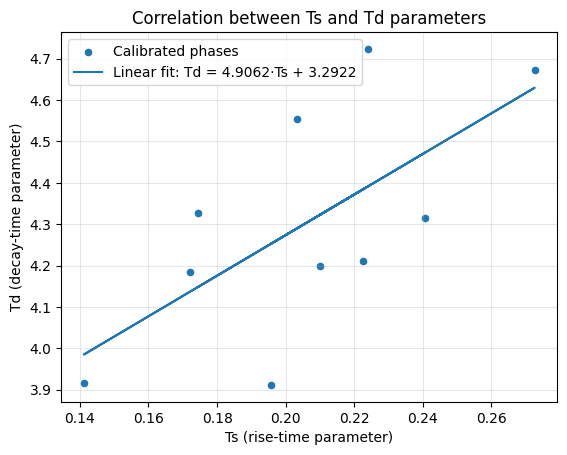

(np.float64(4.906232034365448), np.float64(3.2922252342815397))

In [13]:
# Your model uses pairs: [Ts1, Td1, Ts2, Td2, ...]
ts = center_of_mass[0::2]
td = center_of_mass[1::2]

slope, intercept = np.polyfit(ts, td, 1)
td_fit = slope * ts + intercept

# Correlation between Ts and Td parameters
plt.figure()
plt.scatter(ts, td, s=20, label="Calibrated phases")
plt.plot(ts, td_fit, label=f"Linear fit: Td = {slope:.4f}·Ts + {intercept:.4f}")
plt.xlabel("Ts (rise-time parameter)")
plt.ylabel("Td (decay-time parameter)")
plt.title("Correlation between Ts and Td parameters")
plt.legend()
plt.grid(alpha=0.3)
plt.show(block=False)

slope, intercept

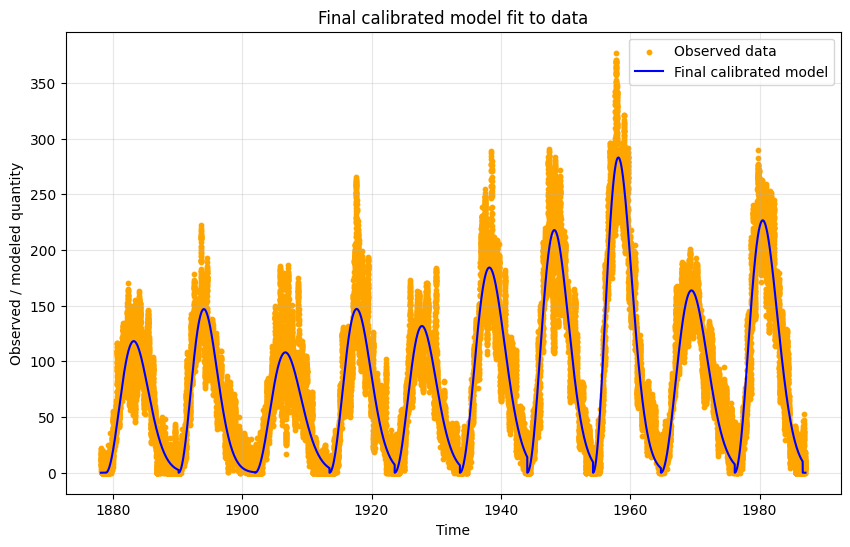

In [19]:
# Final calibrated model compared to observed data
plt.figure(figsize=(10, 6))
plt.scatter(time_points, data_points, color="Orange", s=10, label="Observed data")
plt.plot(time_points, model(time_points, center_of_mass),color='blue', label="Final calibrated model")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Final calibrated model fit to data")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Coefficient of Determination (R²) for the Ts–Td Relationship

To quantify how well the linear fit explains the relationship between `Ts` and `Td`, we compute the coefficient of determination \(R^2\).

First, the residuals are defined as the difference between the observed `Td` values and the values predicted by the fitted linear model. The total sum of squares measures the overall variability of `Td`, while the residual sum of squares measures the variability that is not explained by the linear relationship with `Ts`.

The \(R^2\) value is then computed as

\[
R^2 = 1 - \frac{\mathrm{SS}_{\text{residual}}}{\mathrm{SS}_{\text{total}}}
\]

An \(R^2\) value close to 1 indicates that a large fraction of the variance in `Td` is explained by `Ts`, while a value close to 0 indicates a weak linear relationship. This provides a compact numerical summary that complements the scatter plot and fitted line shown above.

In [20]:
residuals = td - td_fit

ss_total = np.sum((td - np.mean(td)) ** 2)
ss_residual = np.sum(residuals ** 2)

r_squared = 1 - (ss_residual / ss_total)
print(f"R² = {r_squared:.3f}")

R² = 0.429


## Comparison with Literature Values

To place our results in context, we compare the fitted relationship between the model parameters `Ts` and `Td` with values reported in the literature. In solar cycle modeling, these parameters are known to follow a linear relationship, commonly referred to as the *Waldmeier rule*, which links the rise-time and decay-time characteristics of solar cycles.

According to Hathaway (2015) and subsequent studies, this relationship can be expressed as:
\[
T_d = s_1 \, T_s + s_2
\]
with reported values:
- \( s_1 \approx 0.02 \) (per year),
- \( s_2 \approx 3.14 \) years.

These values are derived from empirical analyses of historical solar cycles and are widely used as reference benchmarks in solar activity modeling.

In our implementation, the parameters `Ts` and `Td` are defined using the same functional form but may be expressed in a different time unit. To ensure consistency with the literature, we rescale the fitted slope when necessary (e.g. dividing by 365 when working in daily units). This allows a direct and meaningful comparison between our calibrated parameters and the published reference values.

The numerical comparison and interpretation of our fitted parameters relative to the literature values are presented later, together with the corresponding plots and statistical metrics.

In [42]:
# If the literature reports a slope per year vs per day (or vice versa),
# you may need a rough rescaling depending on your time resolution.
# Teacher example divides by 365 for ~daily resolution.

slope_per_year_est = slope / 365.0
print("slope =", slope)
print("slope/365 =", slope_per_year_est)

# Add your literature target value here once you have it:
# print("Literature slope ~", 0.02)  # example placeholder

slope = 4.906232034365448
slope/365 = 0.013441731601001228


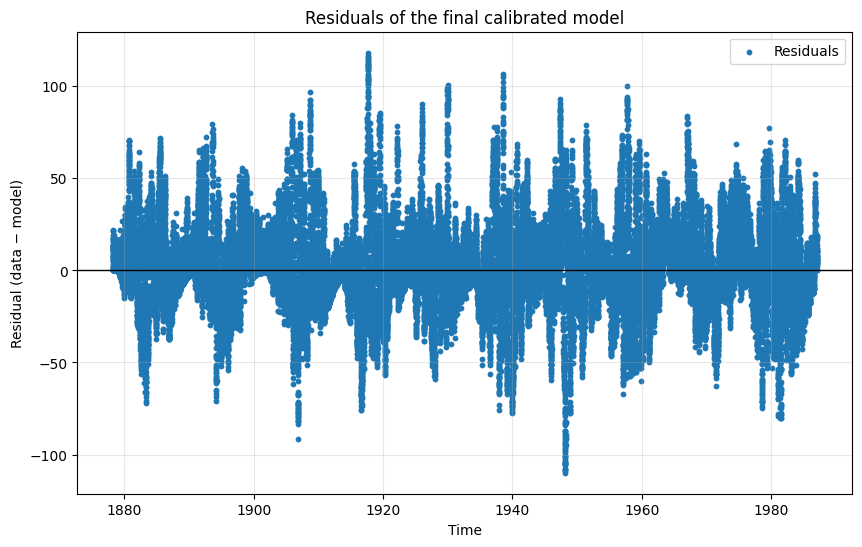

Final MSE = 595.6650684018908


In [22]:
pred = model(time_points, center_of_mass)
res = data_points - pred

# Residuals of the final calibrated model
plt.figure(figsize=(10, 6))
plt.scatter(time_points, res, s=10, label="Residuals")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Residual (data − model)")
plt.title("Residuals of the final calibrated model")
plt.legend()
plt.grid(alpha=0.3)
plt.show(block=False)

print("Final MSE =", np.mean(res**2))

## Results and Discussion 

### Hyperparameter Tuning Results

A systematic hyperparameter tuning was performed on the HPC cluster using an 8 × 8 grid, resulting in a total of 64 independent Simulated Annealing runs. Each run stored its results in JSON files and produced a corresponding loss curve (MSE versus iteration).

As an initial selection step, the loss curves were visually inspected to exclude runs with unstable behaviour (too large step sizes) and runs showing stagnation (too small step sizes). The remaining runs were then compared quantitatively using their final MSE values.

Among the inspected runs, the best-performing hyperparameter configuration was:
- T0 = 10
- step size sigma = 1e-5

This configuration achieved the lowest final MSE in the hyperparameter tuning stage (approximately 596.35) and showed stable and smooth convergence behaviour. These hyperparameters were therefore fixed for all subsequent calibration experiments.
 
---
### Performance Increase with numba Results

To increase the computational performance of the Model Calibration functions, we implemented **Numba** JIT (Just-In-Time) compilation for the computationally intensive model evaluation and loss function calculations. The original implementation already utilized NumPy for numerical operations, but the addition of Numba JIT compilation provides significant performance improvements by compiling Python functions to optimized machine code at runtime.

A performance comparison was conducted by running identical calibration experiments with the same hyperparameters (T0 = 10.0, sigma = 1e-5) and configuration (10 chains, 10,000 iterations, 5,000 burn-in) on a single core. The original implementation (without Numba) achieved a wall time per iteration of approximately 31.4 milliseconds, resulting in a total runtime of 314 seconds for the complete calibration run. After implementing Numba JIT compilation, the wall time per iteration was reduced to 14.9 milliseconds, with a total runtime of 149 seconds.

The implementation achieved a **speedup factor of approximately 2.1x**, effectively halving the computational time required for each iteration. This performance increase is primarily attributed to Numba's ability to compile Python functions to machine code at runtime, eliminating the overhead of Python's interpreter and enabling efficient execution of numerical computations. Importantly, the performance increase did not affect the quality of the solution, as both implementations produced identical final MSE values (823.25), confirming that the numerical results remain unchanged while computational performance is significantly improved.

This performance increase is particularly valuable for large-scale calibration runs with many iterations or when running multiple independent chains, as it directly translates to reduced wall-clock time and improved resource utilization on HPC systems.

---
### Calibration Results

Using the selected hyperparameters, the model was calibrated on the HPC cluster using multiple independent Simulated Annealing chains. The calibration was repeated with different numbers of CPU cores (1, 2, 4, 8, 16, and 32) to study the effect of parallelisation on runtime and solution quality.

The results show that the final MSE is approximately 595.15 for all calibration runs, independent of the number of cores used. This confirms that parallel execution does not affect the quality of the solution, but only reduces the wall-clock runtime.

The wall-clock runtime decreases strongly with increasing core count. Compared to the single-core runtime of about 4155 seconds, the runtime is reduced to approximately 467 seconds when using 16 cores. Increasing the number of cores further to 32 does not lead to a significant additional reduction in runtime, indicating saturation due to parallel overhead and the finite number of independent chains.

The final calibrated model was visually compared to the observed sunspot number data. The model captures the main structure of the solar cycles and reproduces the overall timing of the observed cycles. An analysis of the residuals shows fluctuations around zero without strong systematic trends, indicating that the dominant features of the data are captured by the model.

The calibrated parameters were further analysed to investigate the relationship between the rise-time parameter Ts and the decay-time parameter Td. A scatter plot of Td versus Ts shows a positive correlation, meaning that cycles with longer rise times also tend to have longer decay times. A simple linear regression confirms this positive trend. This qualitative behaviour is consistent with empirical findings reported in the literature.

Overall, the parallel Simulated Annealing approach successfully calibrates the solar cycle model while significantly reducing runtime through HPC parallelisation, without compromising solution quality.



 
 